In [1]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [30]:
import h5py
import matplotlib.pyplot as plt
from skimage import io, img_as_ubyte
import matplotlib.image as mpimg
from scipy import spatial
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                    rotation_range=20,
                                    zoom_range=0.15,
                                    horizontal_flip=True,
                                    validation_split=0.1)


validation_datagen = ImageDataGenerator(rescale=1./225, validation_split=0.1)

train_generator = train_datagen.flow_from_directory(
    '/Users/sudipkhadka/Desktop/Computer-Vision2/Apparel_images',
    target_size=(224, 224),
    batch_size=12,  #32
    class_mode='categorical',
    subset='training'
)

validation_generator = validation_datagen.flow_from_directory(
    '/Users/sudipkhadka/Desktop/Computer-Vision2/Apparel_images',
    target_size=(224, 224),
    batch_size=12,
    class_mode='categorical',
    subset='validation'
)

Found 5167 images belonging to 10 classes.
Found 569 images belonging to 10 classes.


In [3]:
base_model = ResNet50(weights='imagenet', include_top=False)

In [4]:
X = base_model.get_layer('conv5_block3_out').output
X = GlobalAveragePooling2D()(X)
X = Dropout(0.5)(X)

In [5]:
final_layer = Dense(10, activation='softmax')(X)

In [6]:
model = Model(inputs=base_model.input, outputs=final_layer)

In [7]:
#freez all layers up to conv5_block3_out
for layer in base_model.layers:
    layer.trainable = False
    

model.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

In [8]:
# we are going to fine-tune the last 10 layers
for layer in model.layers[-10:]:
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
            loss='categorical_crossentropy',
            metrics=['accuracy'])

In [10]:
checkpoint = ModelCheckpoint('Fine_TunedResnet.keras', 
                             monitor='val_accuracy',  
                             save_best_only=True,     
                             mode='max',             
                             verbose=1)

In [11]:
model_history = model.fit(train_generator,
                        epochs=50,
                        validation_data=validation_generator,
                        callbacks=[checkpoint])

Epoch 1/50


/Users/sudipkhadka/Desktop/Computer-Vision2/.cl/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


431/431 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.2159 - loss: 2.2267

/Users/sudipkhadka/Desktop/Computer-Vision2/.cl/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_accuracy improved from -inf to 0.50439, saving model to Fine_TunedResnet.keras
431/431 ━━━━━━━━━━━━━━━━━━━━ 212s 485ms/step - accuracy: 0.2161 - loss: 2.2263 - val_accuracy: 0.5044 - val_loss: 1.4867
Epoch 2/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.4136 - loss: 1.7137
Epoch 2: val_accuracy improved from 0.50439 to 0.52548, saving model to Fine_TunedResnet.keras
431/431 ━━━━━━━━━━━━━━━━━━━━ 190s 442ms/step - accuracy: 0.4136 - loss: 1.7136 - val_accuracy: 0.5255 - val_loss: 1.3266
Epoch 3/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.4439 - loss: 1.5811
Epoch 3: val_accuracy improved from 0.52548 to 0.55888, saving model to Fine_TunedResnet.keras
431/431 ━━━━━━━━━━━━━━━━━━━━ 195s 453ms/step - accuracy: 0.4439 - loss: 1.5810 - val_accuracy: 0.5589 - val_loss: 1.2833
Epoch 4/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.4717 - loss: 1.4989
Epoch 4: val_accuracy improved from 0.55888 to 0.57469, saving model to Fine_TunedResnet.k

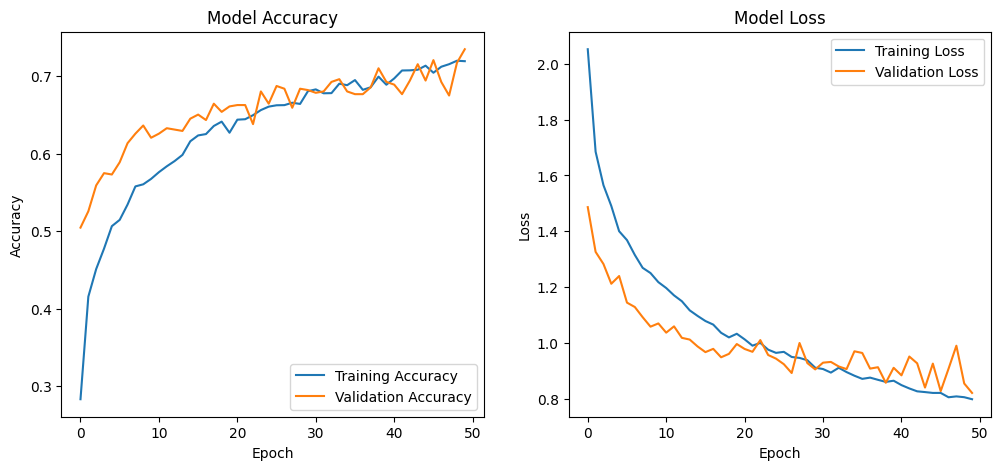

In [18]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(model_history.history['accuracy'], label='Training Accuracy')
plt.plot(model_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(model_history.history['loss'], label='Training Loss')
plt.plot(model_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [12]:
feature_extractor = Model(inputs=model.input,
                        outputs=model.get_layer('conv5_block3_out').output)

In [19]:
def image_preprocessor(path):
    img = tf.keras.utils.load_img(path, target_size=(224, 224))
    img_arr = tf.keras.utils.img_to_array(img)/225.0
    img_arr = tf.expand_dims(img_arr, axis=0)
    features = feature_extractor.predict(img_arr)
    return features.flatten()


In [20]:
images_path = "/Users/sudipkhadka/Desktop/Computer-Vision2/Embedding_imges"

In [31]:

features = []
names = []
for img in os.listdir(images_path):
    if img==".DS_Store":
        continue
    img_path = os.path.join(images_path, img)
    names.append(img_path)
    features.append(image_preprocessor(img_path))

features = np.array(features)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━

In [32]:
output = "Fine_Tuned_RESNET50Features.h5"
h5f = h5py.File(output, "w")
h5f.create_dataset('dataset_1', data=features)
h5f.create_dataset('dataset_2', data=np.string_(names))
h5f.close()

In [33]:
h5f = h5py.File("Fine_Tuned_RESNET50Features.h5", "r")
features = h5f['dataset_1'][:]
image_name = h5f['dataset_2'][:]
h5f.close()

In [34]:
def reterive_similar_image(query_image_path):
    plt.imshow(io.imread(query_image_path))
    plt.title("Query Image")
    plt.show()  

    print("Reteriving Images.........")  
    X = image_preprocessor(query_image_path)

    scores = []
    for i in range(features.shape[0]):
        score  = 1 - spatial.distance.cosine(X, features[i])
        scores.append(score)
    scores = np.array(scores)
    rank_id = np.argsort(scores)[::-1]
    rank_score = scores[rank_id]

    n = 10
    lists = [os.path.join(images_path, image_name[index].decode('utf-8')) if isinstance(image_name[index], bytes) else os.path.join(images_path, image_name[index]) 
         for i, index in enumerate(rank_id[0:n])]

    num_images = len(lists)
    fig, axes = plt.subplots(1, num_images, figsize=(17, 7))
    for i, image_path in enumerate(lists):
        if os.path.exists(image_path):
            img = mpimg.imread(image_path)  
            axes[i].imshow(img)  
            axes[i].axis('off')  
            axes[i].set_title(f"Image Rank {i+1}")
        else:
            print(f"File not found: {image_path}") 
    plt.show()

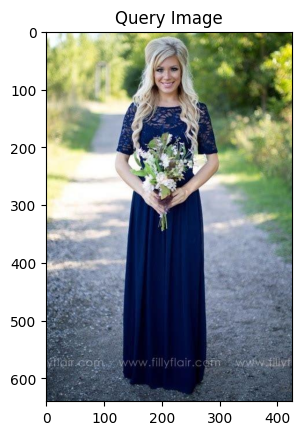

Reteriving Images.........
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


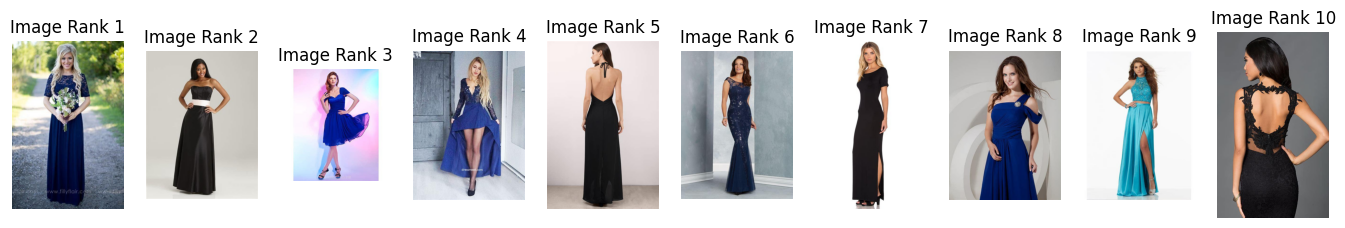

In [35]:
reterive_similar_image('/Users/sudipkhadka/Desktop/Computer-Vision2/query_image/fa3b752a3b52957ec859b26b5dbf7457e8af2513.jpg')

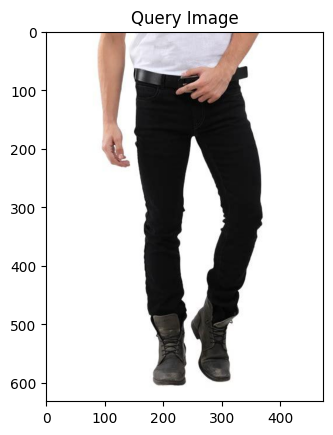

Reteriving Images.........
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


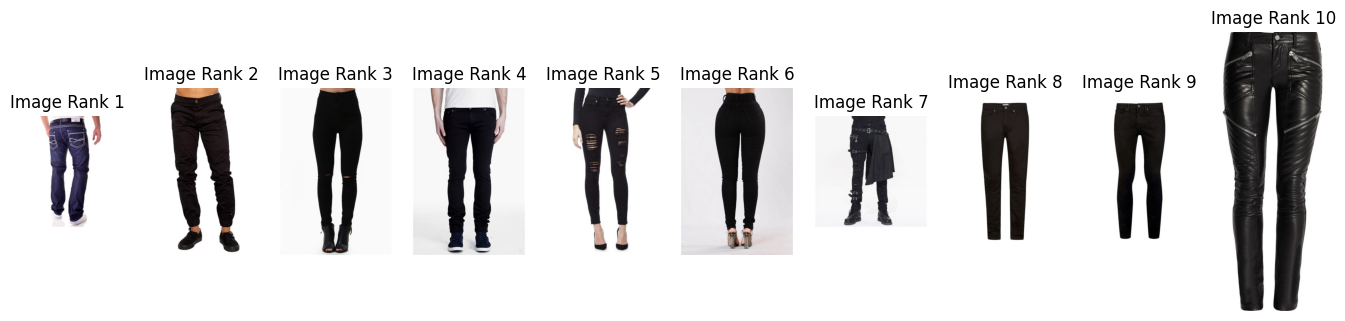

In [28]:
reterive_similar_image('/Users/sudipkhadka/Desktop/Computer-Vision2/query_image/fa60dbf6735fbf1b90977e531d4a4023fc5ec34b.jpg')